In [1]:
import numpy as np
import random
from itertools import permutations
from itertools import product

import math
import matplotlib.pyplot as plt


In [2]:
class soccer_field:
    def __init__(self,positions):
        self.soccer_grid = np.zeros((2,4))
        self.initial_pos = positions
        self.done = False
        if positions[0,1] == 1:
            self.A_has_ball = True
            self.B_has_ball = False
        else:
            self.B_has_ball = True
            self.A_has_ball = False
        
        for i in range(len(positions)):
            if positions[i,0] < 4:
                self.soccer_grid[0,positions[i,0]] = i+1
                col = positions[i,0]
                row = 0
            else:
                self.soccer_grid[1,positions[i,0]-4] = i+1
                col = positions[i,0]-4
                row = 1
                
            if i == 0:
                self.pos_A = [row,col]
            else:
                self.pos_B = [row,col]
        
        self.reward = [0,0]
        
    def print_sg(self,verbose):
        if verbose:
            print(self.soccer_grid)
    
    def initial_state(self):
        if self.A_has_ball:
            init_pos = [[self.pos_A,self.pos_B],[1,0]]
        else:
            init_pos = [[self.pos_A,self.pos_B],[0,1]]
        return [init_pos]
        
    def index_error(self,r,c,action):
        if action == 1 and c+1<np.shape(self.soccer_grid)[1]:
            nex_pos = [r,c+1]
            move = True
        elif action == 2 and c-1>=0:
            move = True
            nex_pos = [r,c-1]
        elif action == 3 and r+1<np.shape(self.soccer_grid)[0]:
            move = True
            nex_pos = [r+1,c]
        elif action == 4 and r-1>=0:
            move = True
            nex_pos = [r-1,c]
        elif action == 0:
            move = True
            nex_pos = [r,c]
        else:
            move = False
            nex_pos = [r,c]
            
        return [move,nex_pos]
    
    def update_position(self,movements):
        for i in range(len(movements)):
            if movements[i,0] == 1:
                [r,c] = self.pos_A
                [move,[r1,c1]] = self.index_error(r,c,movements[i,1])
                    
                if move:
                    if self.soccer_grid[r1,c1] == 0:
                        self.pos_A = [r1,c1]
                        self.soccer_grid[r1,c1] = 1
                        self.soccer_grid[r,c] = 0
                    elif self.soccer_grid[r1,c1] != 0 and self.A_has_ball:
                        self.A_has_ball = False
                        self.B_has_ball = True
            else:
                [r,c] = self.pos_B
                [move,[r1,c1]] = self.index_error(r,c,movements[i,1])
                

                if move:
                    if self.soccer_grid[r1,c1] == 0:
                        self.pos_B  = [r1,c1]
                        self.soccer_grid[r1,c1] = 2
                        self.soccer_grid[r,c] = 0
                    elif self.soccer_grid[r1,c1] != 0 and self.B_has_ball:
                        self.B_has_ball = False     
                        self.A_has_ball = True
                        
        if self.A_has_ball:
            new_pos = [[self.pos_A,self.pos_B],[1,0]]
        else:
            new_pos = [[self.pos_A,self.pos_B],[0,1]]
        
        if (self.pos_A[1] == 0 and self.A_has_ball) or (self.pos_B[1] == 0 and self.B_has_ball):
            self.reward = [100,-100]
            self.done = True
        elif (self.pos_A[1] == 3 and self.A_has_ball) or (self.pos_B[1] == 3 and self.B_has_ball):
            self.reward = [-100,100]
            self.done = True
        #print(self.soccer_grid)
        #print(self.A_has_ball)
        #print(self.reward)
        #print(self.done)
        return [self.reward,new_pos,self.done]

In [3]:
def explore_Greedy(epsilon,v):
    if np.random.rand()<=epsilon:
        return np.random.randint(0,5)
    else:
        loc = np.where(v == np.max(v))[0]
        if len(loc)>1:
            select = random.randint(0,len(loc)-1)
            return np.where(v == np.max(v))[0][select]
        else:
            select = random.randint(0,len(loc)-1)
            return np.where(v == np.max(v))[0][select]
        
    

In [18]:
max_alpha = 1
min_alpha = 0.001
max_eps = 1
min_eps = 0.001
LAMBDA = 0.001
LAMBDA_1 = 0.01

epsilon = max_eps
alpha = max_alpha
gamma = 0.9

r = [0,0]

k = []
for i in range(2):
    for j in range(4):
        k.append([i,j])


perm = permutations(k,2)

all_seq = []

ball = [[0,1],[1,0]]

count = 0
for i in list(perm):
    for j in range(2):
        all_seq.append([list(i),ball[j]])


z = product([0, 1, 2, 3, 4], repeat = 2)

action_list = []
for i in list(z):
    action_list.append(list(i))

Q_A = np.zeros([112,5,5])
Q_B = np.zeros([112,5,5])
step = 0 
done = False
s_a = []

iteration = 500

    
    

def alpha_reduce_2(step,iteration):
    if step <= 0.7*200000:
        m = (0.15-0.2)/(0.7*200000)
        return m*step+0.2
    else:
        m = (0.001-0.15)/(300000-0.7*300000)
        return m*(step-0.7*300000)+0.15

def alpha_reduce_3(step,limit,alpha_max):
    limit=10000000
    if step <= limit:
        m = (0.001-alpha_max)/(limit)
        return m*step+alpha_max
    else:
        return 0.001
    
total_vists = np.zeros([1,5,5])
changes_all = np.zeros([1,5,5])
def alpha_reduce(min_alpha,max_alpha,step):
    return min_alpha + (max_alpha - min_alpha) * math.exp(-LAMBDA_1*step)

#for i in range(iteration):
all_plot=[]
limit = 1000000
total_iter = 0
while total_iter < limit:
    s_p = np.array([[2,0],[1,1]])
    soccer = soccer_field(s_p)
    [state_s] = soccer.initial_state()
    new_pos=state_s
    state = all_seq.index(state_s)
    init_state = all_seq.index(state_s)
    
    done = False
    samp = 1
    
    while not done:
        ###
        action_A = explore_Greedy(epsilon,Q_A[state])
        action_B = explore_Greedy(epsilon,Q_B[state])
        ###
        first = random.randint(1,2)
        prev = list(Q_A[init_state])[4][0].copy()
        #print(new_pos[0])
        #action_A = np.random.randint(0,5)
        #action_B = np.random.randint(0,5)
        
        #V=fri(Q_A[state,],Q_B[state,])
        
        
        if first == 1:
            move = np.array([[1,action_A],[2,action_B]])
        else:
            move = np.array([[2,action_B],[1,action_A]])
        
        [r,new_pos,done] = soccer.update_position(move) 
        state2 = all_seq.index(new_pos)
       
        a_use = action_list.index([action_A,action_B])
        b_use = action_list.index([action_B,action_A])
        
        if r[0] == 0 or r[1] == 0:
            Q_A[state][action_A,action_B] += alpha * ((1-gamma)*r[0] + gamma* np.max(Q_A[state2]) - Q_A[state][action_A,action_B])
            Q_B[state][action_B,action_A] += alpha * ((1-gamma)*r[1] + gamma* np.max(Q_B[state2]) - Q_B[state][action_B,action_A])
            #Q_A[state,action_A] += alpha * (r[0] + gamma* np.max(Q_A[state2,:]) - Q_A[state,action_A])
            #Q_B[state,action_B] += alpha * (r[1] + gamma* np.max(Q_B[state2,:]) - Q_B[state,action_B])
            new = list(Q_A[init_state])[4][0]
            s_a.append([step,np.linalg.norm(np.array(prev)-np.array(new))])
            state = state2
        else:
            #game end
            Q_A[state][action_A,action_B] += alpha * ((1-gamma)*r[0] - Q_A[state][action_A,action_B])
            Q_B[state][action_B,action_A] += alpha * ((1-gamma)*r[1] - Q_B[state][action_B,action_A])     
            new = list(Q_A[init_state])[4][0]
            s_a.append([step,np.linalg.norm(np.array(prev)-np.array(new))])
            #print(new)
            #st
            #if np.linalg.norm(np.array(prev)-np.array(new))>0:
            #s_a.append([step,np.max(np.abs((np.array(prev)-np.array(new))))])
                
        step += 1
        samp = 2
        #epsilon = eps_reduce_2(step,iteration)
    total_iter += 1
    alpha = alpha_reduce_3(total_iter,limit,max_alpha)
        #alpha = alpha_reduce(min_alpha,max_alpha,step)
        #alpha = alpha_reduce_2(step,iteration)
        ##
        #epsilon = alpha_reduce(min_eps,max_eps,step)
        ##
        #print(step)
s_a_use = np.reshape(s_a,[-1,2])

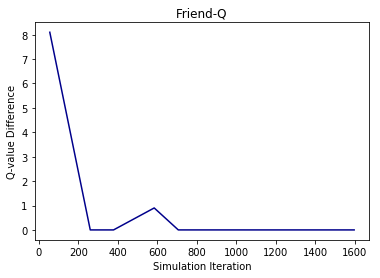

In [20]:
s = np.where(s_a_use[:,1]>0)
k = s_a_use[s,1][0]
plt.rcParams['agg.path.chunksize'] = 10000
#print(k[1000])
#print(s_a[850000:])
p = np.roll(k, 5000)
plt.plot(s_a_use[:,0],s_a_use[:,1],color='darkblue')
#plt.ylim([0,0.05])
#plt.xlim([0,10e5])
plt.xlabel('Simulation Iteration')
plt.ylabel('Q-value Difference')
plt.title('Friend-Q')
plt.show()


[[ 9.         10.          9.          9.          9.        ]
 [ 9.          9.90108748  9.          9.          9.        ]
 [-10.         -10.         -10.         -10.         -10.        ]
 [ 9.          9.          8.99911165  9.          9.        ]
 [ 9.          9.          9.          9.          9.        ]]


[[ 9.          9.         10.          9.          9.        ]
 [-10.         -8.20968343 10.          9.          9.        ]
 [ 9.          9.         10.          9.          9.        ]
 [ 9.          8.91825739 10.          9.          9.        ]
 [ 9.          9.         10.          9.          9.        ]]


[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4]]


[ 0.  0.  0.  0.  0.]


10.0
